In [2]:
import gdown
import os
import cv2
import numpy as np

DATASET_ROOT_DIR = "/content/data"
DATASET_ZIP_PATH = "/content/data.zip"

if not os.path.exists(DATASET_ROOT_DIR):
    file_id = "12jIzLpMwrFq9RTgw0t8NVDCqiyk7Wq5H"
    gdown.download(f"https://drive.google.com/uc?id={file_id}", output=DATASET_ZIP_PATH, quiet=False)
    !unzip -o /content/data.zip -d /content/




Downloading...
From (original): https://drive.google.com/uc?id=12jIzLpMwrFq9RTgw0t8NVDCqiyk7Wq5H
From (redirected): https://drive.google.com/uc?id=12jIzLpMwrFq9RTgw0t8NVDCqiyk7Wq5H&confirm=t&uuid=00f32f25-6b0f-41f1-a6a8-c44de7103e5e
To: /content/data.zip
100%|██████████| 447M/447M [00:05<00:00, 76.8MB/s]


Archive:  /content/data.zip
  inflating: /content/other_filenames.pkl  
  inflating: /content/email_filenames.pkl  
  inflating: /content/doc_filenames.pkl  
  inflating: /content/cv_filenames.pkl  
  inflating: /content/counts.csv     
  inflating: /content/other.npy      
  inflating: /content/ad_filenames.pkl  
  inflating: /content/doc.npy        
  inflating: /content/email.npy      
  inflating: /content/dt/counts.csv  
  inflating: /content/dt/other_filenames.pkl  
  inflating: /content/dt/other.npy   
  inflating: /content/dt/ad_filenames.pkl  
  inflating: /content/dt/email_filenames.pkl  
  inflating: /content/ad.npy         
  inflating: /content/dt/doc_filenames.pkl  
  inflating: /content/dt/cv_filenames.pkl  
  inflating: /content/ad/tob12712.77.tif  
  inflating: /content/cv.npy         
  inflating: /content/ad/tob13927.37.tif  
  inflating: /content/ad/tob08814.21.tif  
  inflating: /content/ad/91659478_9479.tif  
  inflating: /content/dt/email.npy   
  inflating: /con

# **Autoencoder benchmark**

### **1. data preparation**

In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
from sklearn.cluster import KMeans
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

In [ ]:
# Function to load and preprocess images
def load_images(folder_path):
    images = []
    filenames = []
    for filename in os.listdir(folder_path):
        img = cv2.imread(os.path.join(folder_path, filename), cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img = cv2.resize(img, (21, 28))
            images.append(img)
            filenames.append(filename)
    return np.array(images), filenames


1. in this first autoencoder model, the idea was to establish a baseline where the image is resized with 21 pixel width and 28 height.
2. each category is separately loaded in from different folder with filename as label.
3. the npy and pickle files are for the easier running, since everytime it is enough to load those files instead of resizing the images again

In [ ]:
cv, cv_filenames = load_images('cv')
ad, ad_filenames = load_images('ad')
doc, doc_filenames = load_images('doc')
email, email_filenames = load_images('email')
other, other_filenames = load_images('other')

In [ ]:
cv_filenames = ['cv' + filename for filename in cv_filenames]
ad_filenames = ['ad' + filename for filename in ad_filenames]
doc_filenames = ['doc' + filename for filename in doc_filenames]
email_filenames = ['email' + filename for filename in email_filenames]
other_filenames = ['other' + filename for filename in other_filenames]

In [ ]:
cv

array([[[255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255,  44, 255, ..., 255, 255, 255],
        ...,
        [255, 222, 255, ..., 255, 255, 255],
        [255, 250, 249, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255]],

       [[255, 255, 255, ..., 255, 255, 181],
        [255, 255, 255, ...,  21, 255, 181],
        [255, 255, 255, ..., 255, 255, 185],
        ...,
        [255, 255, 255, ..., 255, 255, 185],
        [255, 255, 255, ..., 255, 255, 185],
        [ 74,  74,  74, ...,  73,  87, 205]],

       [[255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        ...,
        [255, 255, 255, ..., 255, 255, 255],
        [255, 200, 255, ..., 253, 255, 255],
        [255, 255, 255, ..., 255, 255, 255]],

       ...,

       [[255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255],
        [255, 255, 255, ..., 255, 255, 255

concatenate the images and filenames, after splitting the training and testing, scale the color value for 0 to 1

In [ ]:
all_images = np.concatenate((cv, ad, doc, email, other), axis=0)
all_filenames = np.concatenate((cv_filenames, ad_filenames, doc_filenames, email_filenames, other_filenames), axis=0)

In [ ]:
from sklearn.model_selection import train_test_split
# train and test split for images and filenames
train, test, train_filenames, test_filenames = train_test_split(all_images, all_filenames, test_size=0.2, random_state=42)

#scale pixel values from 0 to 1
train = train.astype(np.float32) / 255.
test = test.astype(np.float32) / 255.


###  **2. model training**

In [ ]:
class Autoencoder(tf.keras.Model):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        self.encoder = tf.keras.Sequential([
            tf.keras.layers.Flatten(input_shape=(28, 21, 1)),
            tf.keras.layers.Dense(latent_dim, activation='relu')
        ])
        self.decoder = tf.keras.Sequential([
            tf.keras.layers.Dense(28 * 21, activation='sigmoid'),
            tf.keras.layers.Reshape((28, 21, 1))
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

establish some basic default hyperparameter

In [ ]:
latent_dim = 10
num_epochs = 10
batch_size = 32
learning_rate = 0.001

model = Autoencoder(latent_dim)

In [ ]:
model = Autoencoder(latent_dim)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy')

# Train the autoencoder
model.fit(train, train, epochs=num_epochs, batch_size=batch_size)

# Extract latent features using the encoder
latent = model.encoder(test).numpy()

Epoch 1/10
62/62 [==============================] - 1s 3ms/step - loss: 0.4377
Epoch 2/10
62/62 [==============================] - 0s 3ms/step - loss: 0.2829
Epoch 3/10
62/62 [==============================] - 0s 3ms/step - loss: 0.2806
Epoch 4/10
62/62 [==============================] - 0s 3ms/step - loss: 0.2801
Epoch 5/10
62/62 [==============================] - 0s 3ms/step - loss: 0.2797
Epoch 6/10
62/62 [==============================] - 0s 3ms/step - loss: 0.2790
Epoch 7/10
62/62 [==============================] - 0s 3ms/step - loss: 0.2786
Epoch 8/10
62/62 [==============================] - 0s 3ms/step - loss: 0.2783
Epoch 9/10
62/62 [==============================] - 0s 3ms/step - loss: 0.2774
Epoch 10/10
62/62 [==============================] - 0s 3ms/step - loss: 0.2766


### **3. clustering**

In [ ]:
num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
cluster = kmeans.fit_predict(latent)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
# build a dictionary
cluster_filenames = {label: [] for label in range(num_clusters)}

# for every label and filename, append the filename to the corresponding cluster
for label, filename in zip(cluster, test_filenames):
    cluster_filenames[label].append(filename)

# print them
for label in cluster_filenames.keys():
    print(f"Cluster Label {label}:")
    print(cluster_filenames[label])

Cluster Label 0:
['doc504934392+-4392.tif', 'email521901842+-1843.tif', 'doc503215462.tif', 'cv50649495-9496.tif', 'email510782351+-2351.tif', 'doc500330507+-0508.tif', 'other2048394171.tif', 'doc502454975.tif', 'cv50616685-6686.tif', 'doc507874231_507874235.tif', 'cv40010131-0132.tif', 'cv50549559-9560.tif', 'doc500549754_500549755.tif', 'other509134275.tif', 'cv50733631-3632.tif', 'email2075487785b_7786.tif', 'cv40005060-5061.tif', 'email531251012+-1014.tif', 'doc507709424_507709425.tif', 'ad2058501974.tif', 'cv11299985-9986.tif', 'cv50453850-3851.tif', 'cv50477644-7645.tif', 'cv50640076-0076.tif', 'adtob10903.05.tif', 'cv50548483-8484.tif', 'doc511833472.tif', 'cv60001481.tif', 'doc506195313+-5315.tif', 'cv50666555-6556.tif', 'cv50480786-0786.tif', 'email527978548+-8548.tif', 'cv50380841-0842.tif', 'doc500204990.tif', 'cv50662892-2892.tif', 'cv50634425-4426.tif', 'ad2061543271_2061543274.tif', 'cv50633625-3626.tif', 'other531572386+-2388.tif', 'cv50711033-1034.tif', 'cv50341346-1347

### **4. model evaluation**

In [ ]:
import pandas as pd
labels = ['cv', 'ad', 'doc', 'email', 'other']

# build the dictionary
cluster_label_counts = {i: {label: 0 for label in labels} for i in range(5)}

# if the label cv, ad, doc, email, other appeared in filenames, then count of that cluster lable +1
for cluster, filenames in cluster_filenames.items():
    for filename in filenames:
        for label in labels:
            if label in filename:
                cluster_label_counts[cluster][label] += 1

# create the corresponding dataframe
df = pd.DataFrame(cluster_label_counts).T
df['tot'] = df['cv'] + df['ad'] + df['doc'] + df['email'] + df['other']
df.index.name = 'Cluster'

print(df)

         cv  ad  doc  email  other  tot
Cluster                                
0        97  14   41     22     13  187
1         0  22    0      0      2   24
2        25   4   61     53     11  154
3        63  24   11      0     10  108
4         0  16    0      0      0   16


In [ ]:
df = pd.DataFrame(cluster_label_counts).T
df['tot'] = df.sum(axis=1)
df.index.name = 'Cluster'

# the cluster is renamed with the most frequent category
for idx, row in df.iterrows():
    df.at[idx, 'Cluster'] = row[labels].idxmax()

# set the initail value = 0
correct_counts = {label: 0 for label in labels}
total = 0

# calculate the accuracy
for cluster, filenames in cluster_filenames.items():
    for filename in filenames:
        for label in labels:
            if label in filename and df.at[cluster, 'Cluster'] == label:
                correct_counts[label] += 1
        total += 1

accuracies = {label: correct_counts[label] / df['tot'][df['Cluster'] == label].sum() * 100 for label in labels}
accuracies['total'] = sum(correct_counts.values()) / total * 100

print("Accuracy (cv):", accuracies['cv'])
print("Accuracy (ad):", accuracies['ad'])
print("Accuracy (doc):", accuracies['doc'])
print("Accuracy (email):", accuracies['email'])
print("Accuracy (total):", accuracies['total'])



Accuracy (cv): 54.23728813559322
Accuracy (ad): 95.0
Accuracy (doc): 39.61038961038961
Accuracy (email): nan
Accuracy (total): 52.965235173824134


<ipython-input-15-0fc6e55cc391>:21: RuntimeWarning: invalid value encountered in scalar divide
  accuracies = {label: correct_counts[label] / df['tot'][df['Cluster'] == label].sum() * 100 for label in labels}


**the ad is really satisfying as we expected, but the doc and email performed really bad since they are similar type of images, especially when the images are resized in a small size**

# **Autoencoder 2**

### **1. data preparation**

In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
from sklearn.cluster import KMeans
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

**increased the size to 300 width and 400 height, proportional to the original size of 750 and 1000**

In [ ]:
def load_images(folder_path):
    images = []
    filenames = []
    for filename in os.listdir(folder_path):
        img = cv2.imread(os.path.join(folder_path, filename), cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img = cv2.resize(img, (300,400))
            images.append(img)
            filenames.append(filename)
    return np.array(images), filenames


In [ ]:
cv, cv_filenames = load_images('cv')
ad, ad_filenames = load_images('ad')
doc, doc_filenames = load_images('doc')
email, email_filenames = load_images('email')
other, other_filenames = load_images('other')

In [ ]:
cv_filenames = ['cv' + filename for filename in cv_filenames]
ad_filenames = ['ad' + filename for filename in ad_filenames]
doc_filenames = ['doc' + filename for filename in doc_filenames]
email_filenames = ['email' + filename for filename in email_filenames]
other_filenames = ['other' + filename for filename in other_filenames]

In [ ]:
import pickle

np.save('cv.npy', cv)
np.save('ad.npy', ad)
np.save('doc.npy', doc)
np.save('email.npy', email)
np.save('other.npy', other)

with open('cv_filenames.pkl', 'wb') as f:
    pickle.dump(cv_filenames, f)
with open('ad_filenames.pkl', 'wb') as f:
    pickle.dump(ad_filenames, f)
with open('doc_filenames.pkl', 'wb') as f:
    pickle.dump(doc_filenames, f)
with open('email_filenames.pkl', 'wb') as f:
    pickle.dump(email_filenames, f)
with open('other_filenames.pkl', 'wb') as f:
    pickle.dump(other_filenames, f)


In [ ]:
import pickle
cv = np.load('cv.npy')
ad = np.load('ad.npy')
doc = np.load('doc.npy')
email = np.load('email.npy')
other = np.load('other.npy')

with open('cv_filenames.pkl', 'rb') as f:
    cv_filenames = pickle.load(f)
with open('ad_filenames.pkl', 'rb') as f:
    ad_filenames = pickle.load(f)
with open('doc_filenames.pkl', 'rb') as f:
    doc_filenames = pickle.load(f)
with open('email_filenames.pkl', 'rb') as f:
    email_filenames = pickle.load(f)
with open('other_filenames.pkl', 'rb') as f:
    other_filenames = pickle.load(f)


In [ ]:
# check if the size of the image is 400, 300, if not, run the autoencoder 2 again
cv.shape

(909, 400, 300)

In [ ]:
all_images = np.concatenate((cv, ad, doc, email, other), axis=0)
all_filenames = np.concatenate((cv_filenames, ad_filenames, doc_filenames, email_filenames, other_filenames), axis=0)

In [ ]:
from sklearn.model_selection import train_test_split
#test train splitting
train, test, train_filenames, test_filenames = train_test_split(all_images, all_filenames, test_size=0.2, random_state=42)

#scale pixel values from 0 to 1
train = train.astype(np.float32) / 255.
test = test.astype(np.float32) / 255.

### **2. model training**

In [ ]:
class Autoencoder(tf.keras.Model):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        self.encoder = tf.keras.Sequential([
            tf.keras.layers.Flatten(input_shape=(400,300)),
            tf.keras.layers.Dense(latent_dim, activation='relu')
        ])
        self.decoder = tf.keras.Sequential([
            tf.keras.layers.Dense(400*300, activation='sigmoid'),
            tf.keras.layers.Reshape((400, 300))
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [ ]:
latent_dim = 10
num_epochs = 10
batch_size = 32
learning_rate = 0.001

In [ ]:
model = Autoencoder(latent_dim)

# compiling the model with binary crossentropy and adam optimizer
model.compile(optimizer='adam', loss='mean_squared_error')
# train it
model.fit(train, train, epochs=num_epochs, batch_size=batch_size)

# extract features
features = model.encoder(test).numpy()

Epoch 1/10
62/62 [==============================] - 7s 104ms/step - loss: 0.0795
Epoch 2/10
62/62 [==============================] - 6s 98ms/step - loss: 0.0522
Epoch 3/10
62/62 [==============================] - 5s 82ms/step - loss: 0.0512
Epoch 4/10
62/62 [==============================] - 7s 116ms/step - loss: 0.0510
Epoch 5/10
62/62 [==============================] - 5s 82ms/step - loss: 0.0508
Epoch 6/10
62/62 [==============================] - 5s 83ms/step - loss: 0.0507
Epoch 7/10
62/62 [==============================] - 7s 119ms/step - loss: 0.0507
Epoch 8/10
62/62 [==============================] - 5s 82ms/step - loss: 0.0508
Epoch 9/10
62/62 [==============================] - 6s 92ms/step - loss: 0.0505
Epoch 10/10
62/62 [==============================] - 10s 155ms/step - loss: 0.0504


## **3. clustering**

In [ ]:
# divide them into 5 clusters since we have 5 groups
num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
cluster = kmeans.fit_predict(features)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
# set up a dictionary to store the filenames for each category
cluster_filenames = {label: [] for label in range(num_clusters)}

# Iterate over each cluster label and corresponding filename
for label, filename in zip(cluster, test_filenames):
    # append the filename for the corresponding cluster
    if label in cluster_filenames:
        cluster_filenames[label].append(filename)

# give a glance of the result
for label, filenames in cluster_filenames.items():
    print(f"Cluster Label {label}:")
    print(filenames)

Cluster Label 0:
['doc504934392+-4392.tif', 'doc506178405.tif', 'other530427528+-7528.tif', 'other528694697+-4698.tif', 'email2067238977.tif', 'doc511771323+-1323.tif', 'other0000331927.tif', 'email81857919.tif', 'email2074939056.tif', 'other503372273_503372325.tif', 'doc505032119_505032120.tif', 'doc504740107.tif', 'email531251012+-1014.tif', 'doc514339296+-9299.tif', 'doc502406827.tif', 'email2071864234a_4235.tif', 'ad502141060.tif', 'doc502265984_502266019.tif', 'doc502524610.tif', 'adtob10903.05.tif', 'email2067314159.tif', 'doc511833472.tif', 'email528751886+-1887.tif', 'cv50359301-9301.tif', 'doc504741279_504741280.tif', 'email2078446254.tif', 'email527978548+-8548.tif', 'doc514290478+-0478.tif', 'doc502131188_502131192.tif', 'doc506136396.tif', 'doc500204990.tif', 'doc0001477447.tif', 'doc504363180+-3182.tif', 'email526689833+-9833.tif', 'doc513833108.tif', 'ad509134489.tif', 'doc512695664+-5664.tif', 'doc507710859+-0861.tif', 'doc500024044.tif', 'doc500314811.tif', 'doc50239426

In [ ]:
# labels
import pandas as pd
labels = ['cv', 'ad', 'doc', 'email', 'other']

# set up a dictionary to count occurrencies for each category
cluster_label_counts = {i: {label: 0 for label in labels} for i in range(5)}

# if the label cv, ad, doc, email, other appeared in filenames, then count of that cluster lable +1
for cluster, filenames in cluster_filenames.items():
    for filename in filenames:
        for label in labels:
            if label in filename:
                cluster_label_counts[cluster][label] += 1

# create the corresponding dataframe
df = pd.DataFrame(cluster_label_counts).T
df['tot'] = df['cv'] + df['ad'] + df['doc'] + df['email'] + df['other']


df.index.name = 'Cluster'

df

,cv,ad,doc,email,other,tot
Cluster,,,,,,
0,5,9,57,54,9,134
1,0,16,0,0,0,16
2,2,25,3,0,3,33
3,93,10,43,20,16,182
4,85,20,10,1,8,124


In [ ]:
df.to_csv('counts.csv',index=False)
dt = pd.read_csv('counts.csv')
dt

,cv,ad,doc,email,other,tot
0,5,9,57,54,9,134
1,0,16,0,0,0,16
2,2,25,3,0,3,33
3,93,10,43,20,16,182
4,85,20,10,1,8,124


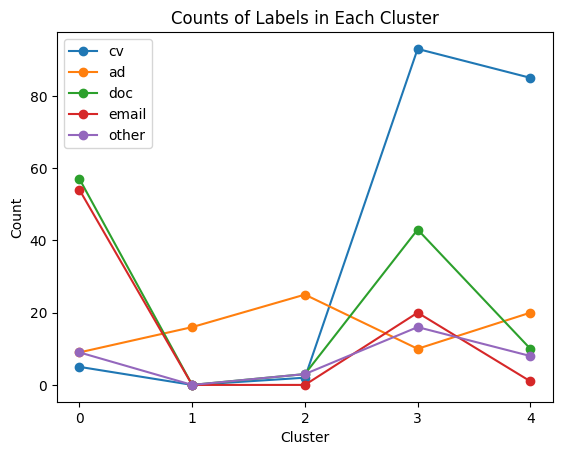

In [ ]:
import matplotlib.pyplot as plt

# Plot DataFrame as a line plot
df.drop(columns='tot').plot(kind='line', marker='o')

# Set x-ticks at integer positions
plt.xticks(range(len(df)))

# Add labels and title
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.title('Counts of Labels in Each Cluster')

# Show plot
plt.show()


## **4. model evaluation**

In [ ]:
# calculate percentage of each label
df_percent = df.copy()
for label in labels:
    df_percent[label] = df_percent[label] / df_percent['tot'] * 100

# rename the cluster with the label with the highest percentage in each row
df_percent['Highest Percentage Label'] = df_percent[labels].idxmax(axis=1)

df_percent


,cv,ad,doc,email,other,tot,Highest Percentage Label
Cluster,,,,,,,
0,3.731343,6.716418,42.537313,40.298507,6.716418,134,doc
1,0.000000,100.000000,0.000000,0.000000,0.000000,16,ad
2,6.060606,75.757576,9.090909,0.000000,9.090909,33,ad
3,51.098901,5.494505,23.626374,10.989011,8.791209,182,cv
4,68.548387,16.129032,8.064516,0.806452,6.451613,124,cv


In [ ]:
df = pd.DataFrame(cluster_label_counts).T
df['tot'] = df.sum(axis=1)
df.index.name = 'Cluster'

# the cluster is renamed with the most frequent category
for idx, row in df.iterrows():
    df.at[idx, 'Cluster'] = row[labels].idxmax()

# create a dictionary and set the initail value = 0
correct_counts = {label: 0 for label in labels}
total = 0

# calculate the accuracy
for cluster, filenames in cluster_filenames.items():
    for filename in filenames:
        for label in labels:
            if label in filename and df.at[cluster, 'Cluster'] == label:
                correct_counts[label] += 1
        total += 1

accuracies = {label: correct_counts[label] / df['tot'][df['Cluster'] == label].sum() * 100 for label in labels}
accuracies['total'] = sum(correct_counts.values()) / total * 100

print("Accuracy (cv):", accuracies['cv'])
print("Accuracy (ad):", accuracies['ad'])
print("Accuracy (doc):", accuracies['doc'])
print("Accuracy (email):", accuracies['email'])
print("Accuracy (other):", accuracies['other'])
print("Accuracy (total):", accuracies['total'])

Accuracy (cv): 58.16993464052288
Accuracy (ad): 83.6734693877551
Accuracy (doc): 42.53731343283582
Accuracy (email): nan
Accuracy (other): nan
Accuracy (total): 56.44171779141104


<ipython-input-34-9ffd813ab46d>:21: RuntimeWarning: invalid value encountered in scalar divide
  accuracies = {label: correct_counts[label] / df['tot'][df['Cluster'] == label].sum() * 100 for label in labels}


**there is an improvement but still it is not able to separate doc and emails**

# **Autoencoder 3**

In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
from sklearn.cluster import KMeans
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

## **1. data preparation**

introduced new function of removing the black borders

In [3]:
def remove_black_border(image):
    _, binary = cv2.threshold(image, 1, 255, cv2.THRESH_BINARY)
    coords = cv2.findNonZero(binary)
    x, y, w, h = cv2.boundingRect(coords)
    cropped_image = image[y:y+h, x:x+w]
    return cropped_image

def load_images(folder_path):
    images = []
    filenames = []
    for filename in os.listdir(folder_path):
        img = cv2.imread(os.path.join(folder_path, filename), cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img = remove_black_border(img)
            img = cv2.resize(img, (300, 400))
            images.append(img)
            filenames.append(filename)
    return np.array(images), filenames

In [4]:
cv, cv_filenames = load_images('cv')
ad, ad_filenames = load_images('ad')
doc, doc_filenames = load_images('doc')
email, email_filenames = load_images('email')

In [9]:
cv_filenames[1]

'50684275-4275.tif'

In [10]:
cv_filenames = ['cv' + filename for filename in cv_filenames]
ad_filenames = ['ad' + filename for filename in ad_filenames]
doc_filenames = ['doc' + filename for filename in doc_filenames]
email_filenames = ['email' + filename for filename in email_filenames]

In [11]:
cv_filenames[1]

'cv50684275-4275.tif'

In [12]:
import pickle



np.save('cv.npy', cv)
np.save('ad.npy', ad)
np.save('doc.npy', doc)
np.save('email.npy', email)


with open('cv_filenames.pkl', 'wb') as f:
    pickle.dump(cv_filenames, f)
with open('ad_filenames.pkl', 'wb') as f:
    pickle.dump(ad_filenames, f)
with open('doc_filenames.pkl', 'wb') as f:
    pickle.dump(doc_filenames, f)
with open('email_filenames.pkl', 'wb') as f:
    pickle.dump(email_filenames, f)


[Errno 2] No such file or directory: '/content/drive/MyDrive/machine learning/reply/zhao/dt'
/content


In [ ]:
import pickle
cv = np.load('cv.npy')
ad = np.load('ad.npy')
doc = np.load('doc.npy')
email = np.load('email.npy')


with open('cv_filenames.pkl', 'rb') as f:
    cv_filenames = pickle.load(f)
with open('ad_filenames.pkl', 'rb') as f:
    ad_filenames = pickle.load(f)
with open('doc_filenames.pkl', 'rb') as f:
    doc_filenames = pickle.load(f)
with open('email_filenames.pkl', 'rb') as f:
    email_filenames = pickle.load(f)



In [ ]:
all_images = np.concatenate((cv, ad, doc, email), axis=0)
all_filenames = np.concatenate((cv_filenames, ad_filenames, doc_filenames, email_filenames), axis=0)

In [ ]:
all_images = all_images.astype(np.float32) / 255.


In [ ]:
all_images[1]

array([[0.        , 0.        , 0.44313726, ..., 1.        , 1.        ,
        1.        ],
       [0.        , 0.        , 0.6862745 , ..., 1.        , 1.        ,
        1.        ],
       [0.        , 0.        , 0.85490197, ..., 1.        , 1.        ,
        1.        ],
       ...,
       [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ],
       [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ],
       [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
        1.        ]], dtype=float32)

## **2. model training**

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

class Autoencoder(tf.keras.Model):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        self.encoder = tf.keras.Sequential([
            layers.Flatten(input_shape=(400, 300)),
            layers.Dense(latent_dim, activation='relu')
        ])
        self.decoder = tf.keras.Sequential([
            layers.Dense(400 * 300, activation='sigmoid'),
            layers.Reshape((400, 300))
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded




In [ ]:
latent_dim = 10
num_epochs = 10
batch_size = 32
learning_rate = 0.001

autoencoder = Autoencoder(latent_dim)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

autoencoder.fit(all_images, all_images, epochs=10, batch_size=32)

Epoch 1/10
69/69 [==============================] - 8s 112ms/step - loss: 0.0746
Epoch 2/10
69/69 [==============================] - 6s 86ms/step - loss: 0.0520
Epoch 3/10
69/69 [==============================] - 6s 93ms/step - loss: 0.0516
Epoch 4/10
69/69 [==============================] - 8s 109ms/step - loss: 0.0513
Epoch 5/10
69/69 [==============================] - 6s 83ms/step - loss: 0.0514
Epoch 6/10
69/69 [==============================] - 8s 118ms/step - loss: 0.0511
Epoch 7/10
69/69 [==============================] - 7s 103ms/step - loss: 0.0510
Epoch 8/10
69/69 [==============================] - 10s 148ms/step - loss: 0.0509
Epoch 9/10
69/69 [==============================] - 6s 86ms/step - loss: 0.0510
Epoch 10/10
69/69 [==============================] - 7s 106ms/step - loss: 0.0508


In [ ]:
latent_features = autoencoder.encoder.predict(all_images)


69/69 [==============================] - 1s 17ms/step


## **3. clustering**

In [ ]:
from sklearn.cluster import KMeans

num_clusters = 25
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(latent_features)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
# set up a dictionary to store the filenames for each category
cluster_filenames = {i: [] for i in range(num_clusters)}
for label, filename in zip(cluster_labels, all_filenames):
    cluster_filenames[label].append(filename)

# give a glance of the result
for label, filenames in cluster_filenames.items():
    print(f"Cluster Label {label}:")
    print(filenames)

Cluster Label 0:
['cv50684275-4275.tif', 'cv50725325-5326.tif', 'cv50394836-4837.tif', 'cv50573173-3174.tif', 'cv50440489-0490.tif', 'cv50406480-6480.tif', 'cv50451098-1099.tif', 'cv50495036-5037.tif', 'cv50426269-6270.tif', 'cv50664550-4550.tif', 'cv50464592-4592.tif', 'cv50443584-3584.tif', 'cv50404927-4927.tif', 'cv50654890-4891.tif', 'cv40038957-8958.tif', 'cv50704157-4157.tif', 'cv50565789-5790.tif', 'cv50703730-3731.tif', 'cv50480784-0785.tif', 'cv50428241-8242.tif', 'cv50448503-8504.tif', 'cv40014110-4111.tif', 'cv50517618-7619.tif', 'cv50363055-3056.tif', 'cv40047224-7225.tif', 'cv50566956-6956.tif', 'cv50670124-0125.tif', 'cv50726040-6040.tif', 'cv50370352-0353.tif', 'cv50571232-1232.tif', 'cv50612717-2718.tif', 'cv50357857-7858.tif', 'cv50567184-7185.tif', 'cv40041339-1341.tif', 'cv50724528-4529.tif', 'cv50509349-9350.tif', 'cv50634425-4426.tif', 'cv50456338-6339.tif', 'cv50267523-7526.tif', 'cv50569673-9674.tif', 'cv50571585-1586.tif', 'cv50698908-8908.tif', 'cv50707565-7566

In [ ]:
# labels
import pandas as pd
labels = ['cv', 'ad', 'doc', 'email']

# count the occurrencies
cluster_label_counts = {i: {label: 0 for label in labels} for i in range(num_clusters)}
for cluster, filenames in cluster_filenames.items():
    for filename in filenames:
        for label in labels:
            if label in filename:
                cluster_label_counts[cluster][label] += 1


df = pd.DataFrame(cluster_label_counts).T
df['tot'] = df['cv'] + df['ad'] + df['doc'] + df['email']

df.index.name = 'Cluster'

print(df)

          cv  ad  doc  email  tot
Cluster                          
0        130  15   34     17  196
1          0  29    3      0   32
2          0   4   66     53  123
3         89  11   11      0  111
4          0  16    2      0   18
5         40   8   83     73  204
6          3  29    6      1   39
7          0   2    2      0    4
8          0  19    0      0   19
9        167  16   11      3  197
10        23  39   10      0   72
11         5   8   84     93  190
12         0   5    9      0   14
13         0   6    1      0    7
14        87  11   40     38  176
15         0  26    0      0   26
16         1  31    2      0   34
17         0   0    2      0    2
18         1   1  104     73  179
19       161  13   11      1  186
20         0  25    0      0   25
21       144  16   26      9  195
22        58  32   10      1  101
23         0   0   27      7   34
24         0  19    0      0   19


## **4. model evaluation**

In [ ]:
import pandas as pd

# create a dictionary to store occurrencies of labels
labels = ['cv', 'ad', 'doc', 'email']
cluster_label_counts = {i: {label: 0 for label in labels} for i in range(num_clusters)}

# count occurrencies
for cluster, filenames in cluster_filenames.items():
    for filename in filenames:
        for label in labels:
            if label in filename:
                cluster_label_counts[cluster][label] += 1


df = pd.DataFrame(cluster_label_counts).T
df['tot'] = df.sum(axis=1)
df.index.name = 'Cluster'

# rename clusters based on label frequency
for idx, row in df.iterrows():
    df.at[idx, 'Cluster'] = row[labels].idxmax()

# set the initial counts to 0
correct_counts = {label: 0 for label in labels}
total = 0

# check the accuracy
for cluster, filenames in cluster_filenames.items():
    for filename in filenames:
        for label in labels:
            if label in filename and df.at[cluster, 'Cluster'] == label:
                correct_counts[label] += 1
        total += 1

#calculate accuracy for each label
accuracies = {label: correct_counts[label] / df['tot'][df['Cluster'] == label].sum() * 100 for label in labels}
accuracies['total'] = sum(correct_counts.values()) / total * 100

print("Accuracy (cv):", accuracies['cv'])
print("Accuracy (ad):", accuracies['ad'])
print("Accuracy (doc):", accuracies['doc'])
print("Accuracy (email):", accuracies['email'])
print("Accuracy (total):", accuracies['total'])


Accuracy (cv): 71.9449225473322
Accuracy (ad): 81.69491525423729
Accuracy (doc): 52.33812949640287
Accuracy (email): 48.94736842105264
Accuracy (total): 66.31865637766681


In [ ]:
# Calculate percentage of each label relative to 'tot' in each row
df_percent = df.copy()
for label in labels:
    df_percent[label] = df_percent[label] / df_percent['tot'] * 100

# Find the label with the highest percentage in each row
df_percent['Highest Percentage Label'] = df_percent[labels].idxmax(axis=1)

# Display the DataFrame with percentages and highest percentage labels
df_percent

,cv,ad,doc,email,tot,Cluster,Highest Percentage Label
Cluster,,,,,,,
0,66.326531,7.653061,17.346939,8.673469,196,cv,cv
1,0.000000,90.625000,9.375000,0.000000,32,ad,ad
2,0.000000,3.252033,53.658537,43.089431,123,doc,doc
3,80.180180,9.909910,9.909910,0.000000,111,cv,cv
4,0.000000,88.888889,11.111111,0.000000,18,ad,ad
5,19.607843,3.921569,40.686275,35.784314,204,doc,doc
6,7.692308,74.358974,15.384615,2.564103,39,ad,ad
7,0.000000,50.000000,50.000000,0.000000,4,ad,ad
8,0.000000,100.000000,0.000000,0.000000,19,ad,ad


# **autoencoder cross validation**

if the session crushed for the RAM, rum directly from here

## **1. data preparation**

In [22]:
import gdown
import os
import cv2
import numpy as np

DATASET_ROOT_DIR = "/content/data"
DATASET_ZIP_PATH = "/content/data.zip"

if not os.path.exists(DATASET_ROOT_DIR):
    file_id = "12jIzLpMwrFq9RTgw0t8NVDCqiyk7Wq5H"
    gdown.download(f"https://drive.google.com/uc?id={file_id}", output=DATASET_ZIP_PATH, quiet=False)
    !unzip -o /content/data.zip -d /content/


Downloading...
From (original): https://drive.google.com/uc?id=12jIzLpMwrFq9RTgw0t8NVDCqiyk7Wq5H
From (redirected): https://drive.google.com/uc?id=12jIzLpMwrFq9RTgw0t8NVDCqiyk7Wq5H&confirm=t&uuid=1a73c687-f24f-4df2-9553-e08a574acfba
To: /content/data.zip
100%|██████████| 447M/447M [00:04<00:00, 103MB/s] 


Archive:  /content/data.zip
  inflating: /content/other_filenames.pkl  
  inflating: /content/email_filenames.pkl  
  inflating: /content/doc_filenames.pkl  
  inflating: /content/cv_filenames.pkl  
  inflating: /content/counts.csv     
  inflating: /content/other.npy      
  inflating: /content/ad_filenames.pkl  
  inflating: /content/doc.npy        
  inflating: /content/email.npy      
  inflating: /content/dt/counts.csv  
  inflating: /content/dt/other_filenames.pkl  
  inflating: /content/dt/other.npy   
  inflating: /content/dt/ad_filenames.pkl  
  inflating: /content/dt/email_filenames.pkl  
  inflating: /content/ad.npy         
  inflating: /content/dt/doc_filenames.pkl  
  inflating: /content/dt/cv_filenames.pkl  
  inflating: /content/ad/tob12712.77.tif  
  inflating: /content/cv.npy         
  inflating: /content/ad/tob13927.37.tif  
  inflating: /content/ad/tob08814.21.tif  
  inflating: /content/ad/91659478_9479.tif  
  inflating: /content/dt/email.npy   
  inflating: /con

In [1]:
#!pip install --upgrade tensorflow keras

import pickle
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split, GridSearchCV
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import KFold
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [23]:
def remove_black_border(image):
    _, binary = cv2.threshold(image, 1, 255, cv2.THRESH_BINARY)
    coords = cv2.findNonZero(binary)
    x, y, w, h = cv2.boundingRect(coords)
    cropped_image = image[y:y+h, x:x+w]
    return cropped_image

def load_images(folder_path):
    images = []
    filenames = []
    for filename in os.listdir(folder_path):
        img = cv2.imread(os.path.join(folder_path, filename), cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img = remove_black_border(img)
            img = cv2.resize(img, (300, 400))
            images.append(img)
            filenames.append(filename)
    return np.array(images), filenames

In [24]:
cv, cv_filenames = load_images('cv')
ad, ad_filenames = load_images('ad')
doc, doc_filenames = load_images('doc')
email, email_filenames = load_images('email')

In [25]:
cv_filenames = ['cv' + filename for filename in cv_filenames]
ad_filenames = ['ad' + filename for filename in ad_filenames]
doc_filenames = ['doc' + filename for filename in doc_filenames]
email_filenames = ['email' + filename for filename in email_filenames]

In [26]:
import pickle

np.save('cv.npy', cv)
np.save('ad.npy', ad)
np.save('doc.npy', doc)
np.save('email.npy', email)

with open('cv_filenames.pkl', 'wb') as f:
    pickle.dump(cv_filenames, f)
with open('ad_filenames.pkl', 'wb') as f:
    pickle.dump(ad_filenames, f)
with open('doc_filenames.pkl', 'wb') as f:
    pickle.dump(doc_filenames, f)
with open('email_filenames.pkl', 'wb') as f:
    pickle.dump(email_filenames, f)


In [27]:
cv = np.load('cv.npy')
ad = np.load('ad.npy')
doc = np.load('doc.npy')
email = np.load('email.npy')

with open('cv_filenames.pkl', 'rb') as f:
    cv_filenames = pickle.load(f)
with open('ad_filenames.pkl', 'rb') as f:
    ad_filenames = pickle.load(f)
with open('doc_filenames.pkl', 'rb') as f:
    doc_filenames = pickle.load(f)
with open('email_filenames.pkl', 'rb') as f:
    email_filenames = pickle.load(f)

In [28]:
all_images = np.concatenate((cv, ad, doc, email), axis=0)
all_filenames = np.concatenate((cv_filenames, ad_filenames, doc_filenames, email_filenames), axis=0)

In [29]:
all_images = all_images.astype(np.float32) / 255.0
all_filenames.shape

(2203,)

In [30]:
train_images, val_images, train_filenames, val_filenames = train_test_split(all_images, all_filenames, test_size=0.2, random_state=42)

## **2. model training**

In [5]:
class Autoencoder(tf.keras.Model):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        self.encoder = tf.keras.Sequential([
            layers.Flatten(input_shape=(400, 300)),
            layers.Dense(latent_dim, activation='relu')
        ])
        self.decoder = tf.keras.Sequential([
            layers.Dense(400 * 300, activation='sigmoid'),
            layers.Reshape((400, 300))
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Function to create the autoencoder model for KerasClassifier
def create_autoencoder(latent_dim=10, learning_rate=0.001):
    autoencoder = Autoencoder(latent_dim)
    autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                        loss='mean_squared_error')
    return autoencoder

### **hyperparameter tuning**

the ram do not support to hypertune all the parameters together, so we will tuned them separately

In [6]:
def hyperparameter_tuning(param_grid, train_images, val_images):
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    best_score = float('inf')
    best_params = None

    for latent_dim in param_grid['latent_dim']:
        for learning_rate in param_grid['learning_rate']:
            for batch_size in param_grid['batch_size']:
                for epochs in param_grid['epochs']:
                    print(f"Training with latent_dim={latent_dim}, learning_rate={learning_rate}, batch_size={batch_size}, epochs={epochs}")

                    # train the autoencoder with respective hyperparameters
                    autoencoder = create_autoencoder(latent_dim, learning_rate)
                    history = autoencoder.fit(train_images, train_images,
                                              epochs=epochs,
                                              batch_size=batch_size,
                                              validation_data=(val_images, val_images),
                                              callbacks=[early_stopping],
                                              verbose=1)

                    # evaluate the performance
                    val_loss = min(history.history['val_loss'])

                    # update the best parameters by substituting the best one
                    if val_loss < best_score:
                        best_score = val_loss
                        best_params = {
                            'latent_dim': latent_dim,
                            'learning_rate': learning_rate,
                            'batch_size': batch_size,
                            'epochs': epochs
                        }

    print(f"Best parameters: {best_params}")
    print(f"Best validation loss: {best_score}")
    return best_params, best_score


In [3]:
def evaluate_clustering(latent_features, all_filenames, num_clusters):
    # kmeans clustering
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(latent_features)

    # set up a dictionary
    cluster_filenames = {i: [] for i in range(num_clusters)}
    for label, filename in zip(cluster_labels, all_filenames):
        cluster_filenames[label].append(filename)

    # labels
    labels = ['cv', 'ad', 'doc', 'email']

    # dictionary to store counts for each cluster and label
    cluster_label_counts = {i: {label: 0 for label in labels} for i in range(num_clusters)}

    # count occurrences of each label in cluster filenames
    for cluster, filenames in cluster_filenames.items():
        for filename in filenames:
            for label in labels:
                if label in filename:
                    cluster_label_counts[cluster][label] += 1

    df = pd.DataFrame(cluster_label_counts).T
    df['tot'] = df.sum(axis=1)
    df.index.name = 'Cluster'

    # rename clusters based on label frequency
    for idx, row in df.iterrows():
        df.at[idx, 'Cluster'] = row[labels].idxmax()

    correct_counts = {label: 0 for label in labels}
    total = 0

    # check the accuracy
    for cluster, filenames in cluster_filenames.items():
        for filename in filenames:
            for label in labels:
                if label in filename and df.at[cluster, 'Cluster'] == label:
                    correct_counts[label] += 1
            total += 1

    # calculate accuracy
    accuracies = {label: correct_counts[label] / df['tot'][df['Cluster'] == label].sum() * 100 for label in labels}
    accuracies['total'] = sum(correct_counts.values()) / total * 100

    return accuracies['total']

### **first tuning**

after clustering, the accuracy is 66.48%

In [12]:
param_grid = {
    'latent_dim': [10],
    'learning_rate': [0.001],
    'batch_size': [8, 16],
    'epochs': [10]
}

train_images, val_images = train_test_split(all_images, test_size=0.2, random_state=42)
best_params, best_score = hyperparameter_tuning(param_grid, train_images, val_images)

Training with latent_dim=10, learning_rate=0.001, batch_size=8, epochs=10
Epoch 1/10
221/221 [==============================] - 12s 47ms/step - loss: 0.2067 - val_loss: 0.1898
Epoch 2/10
221/221 [==============================] - 11s 52ms/step - loss: 0.1747 - val_loss: 0.1603
Epoch 3/10
221/221 [==============================] - 12s 53ms/step - loss: 0.1482 - val_loss: 0.1369
Epoch 4/10
221/221 [==============================] - 11s 49ms/step - loss: 0.1273 - val_loss: 0.1187
Epoch 5/10
221/221 [==============================] - 10s 47ms/step - loss: 0.1113 - val_loss: 0.1048
Epoch 6/10
221/221 [==============================] - 12s 53ms/step - loss: 0.0990 - val_loss: 0.0941
Epoch 7/10
221/221 [==============================] - 12s 54ms/step - loss: 0.0896 - val_loss: 0.0860
Epoch 8/10
221/221 [==============================] - 10s 44ms/step - loss: 0.0824 - val_loss: 0.0798
Epoch 9/10
221/221 [==============================] - 13s 59ms/step - loss: 0.0769 - val_loss: 0.0750
Epoch 10

In [16]:
# model with the best parameters
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=3, restore_best_weights=True)
best_autoencoder = create_autoencoder(latent_dim=best_params['latent_dim'], learning_rate=best_params['learning_rate'])
history = best_autoencoder.fit(train_images, train_images,
                               epochs=best_params['epochs'],
                               batch_size=best_params['batch_size'],
                               validation_data=(val_images, val_images),
                               callbacks=[early_stopping],
                               verbose=1)

latent_features = best_autoencoder.encoder.predict(all_images)

Epoch 1/10
111/111 [==============================] - 14s 108ms/step - loss: 0.0643 - val_loss: 0.0526
Epoch 2/10
111/111 [==============================] - 7s 61ms/step - loss: 0.0523 - val_loss: 0.0525
Epoch 3/10
111/111 [==============================] - 9s 78ms/step - loss: 0.0521 - val_loss: 0.0525
Epoch 4/10
111/111 [==============================] - 9s 79ms/step - loss: 0.0518 - val_loss: 0.0524
Epoch 5/10
111/111 [==============================] - 9s 79ms/step - loss: 0.0516 - val_loss: 0.0528
Epoch 6/10
111/111 [==============================] - 7s 60ms/step - loss: 0.0516 - val_loss: 0.0531
Epoch 7/10
69/69 [==============================] - 1s 11ms/step


In [23]:
import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=FutureWarning, module='sklearn')
warnings.filterwarnings("ignore", category=RuntimeWarning)

best_score = 0
best_clusters = 0
max_clusters = 35

for n_clusters in range(1, max_clusters + 1):
    total_accuracy = evaluate_clustering(latent_features, all_filenames, n_clusters)
    if total_accuracy > best_score:
        best_score = total_accuracy
        best_clusters = n_clusters

# final results will be printed
print(f"Best Number of Clusters: {best_clusters}")
print(f"Best Total Accuracy: {best_score}%")

Best Number of Clusters: 33
Best Total Accuracy: 66.48526077097505%


### **second tuning**

after clustering, the accuracy is 66.35%

In [13]:
param_grid = {
    'latent_dim': [10],
    'learning_rate': [0.001],
    'batch_size': [16],
    'epochs': [10,20]
}

train_images, val_images = train_test_split(all_images, test_size=0.2, random_state=42)
best_params, best_score = hyperparameter_tuning(param_grid, train_images, val_images)

Training with latent_dim=10, learning_rate=0.001, batch_size=16, epochs=10
Epoch 1/10
111/111 [==============================] - 8s 68ms/step - loss: 0.0622 - val_loss: 0.0526
Epoch 2/10
111/111 [==============================] - 8s 74ms/step - loss: 0.0524 - val_loss: 0.0527
Epoch 3/10
111/111 [==============================] - 7s 63ms/step - loss: 0.0521 - val_loss: 0.0535
Epoch 4/10
111/111 [==============================] - 8s 75ms/step - loss: 0.0518 - val_loss: 0.0525
Epoch 5/10
111/111 [==============================] - 7s 59ms/step - loss: 0.0516 - val_loss: 0.0525
Epoch 6/10
111/111 [==============================] - 8s 76ms/step - loss: 0.0515 - val_loss: 0.0526
Epoch 7/10
111/111 [==============================] - 7s 62ms/step - loss: 0.0516 - val_loss: 0.0523
Epoch 8/10
111/111 [==============================] - 9s 79ms/step - loss: 0.0514 - val_loss: 0.0533
Epoch 9/10
111/111 [==============================] - 7s 67ms/step - loss: 0.0512 - val_loss: 0.0530
Epoch 10/10
111/

In [11]:
# model with the best parameters
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=3, restore_best_weights=True)
best_autoencoder = create_autoencoder(latent_dim=best_params['latent_dim'], learning_rate=best_params['learning_rate'])
history = best_autoencoder.fit(train_images, train_images,
                               epochs=best_params['epochs'],
                               batch_size=best_params['batch_size'],
                               validation_data=(val_images, val_images),
                               callbacks=[early_stopping],
                               verbose=1)

latent_features = best_autoencoder.encoder.predict(all_images)

Epoch 1/20
111/111 [==============================] - 8s 66ms/step - loss: 0.0664 - val_loss: 0.0526
Epoch 2/20
111/111 [==============================] - 9s 79ms/step - loss: 0.0523 - val_loss: 0.0525
Epoch 3/20
111/111 [==============================] - 7s 66ms/step - loss: 0.0523 - val_loss: 0.0526
Epoch 4/20
111/111 [==============================] - 9s 78ms/step - loss: 0.0518 - val_loss: 0.0538
Epoch 5/20
111/111 [==============================] - 6s 58ms/step - loss: 0.0518 - val_loss: 0.0523
Epoch 6/20
111/111 [==============================] - 9s 80ms/step - loss: 0.0517 - val_loss: 0.0539
Epoch 7/20
111/111 [==============================] - 6s 58ms/step - loss: 0.0518 - val_loss: 0.0523
Epoch 8/20
111/111 [==============================] - 9s 77ms/step - loss: 0.0514 - val_loss: 0.0523
Epoch 9/20
111/111 [==============================] - 7s 61ms/step - loss: 0.0513 - val_loss: 0.0525
Epoch 10/20
111/111 [==============================] - 9s 79ms/step - loss: 0.0513 - val_lo

In [12]:
import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=FutureWarning, module='sklearn')
warnings.filterwarnings("ignore", category=RuntimeWarning)

best_score = 0
best_clusters = 0
max_clusters = 35

for n_clusters in range(1, max_clusters + 1):
    total_accuracy = evaluate_clustering(latent_features, all_filenames, n_clusters)
    if total_accuracy > best_score:
        best_score = total_accuracy
        best_clusters = n_clusters

# final results will be printed
print(f"Best Number of Clusters: {best_clusters}")
print(f"Best Total Accuracy: {best_score}%")

Best Number of Clusters: 18
Best Total Accuracy: 66.34920634920634%


### **third tuning**

after clustering, the accuracy is 65.98%

In [9]:
param_grid = {
    'latent_dim': [10,20],
    'learning_rate': [0.001],
    'batch_size': [16],
    'epochs': [20]
}

train_images, val_images = train_test_split(all_images, test_size=0.2, random_state=42)
best_params, best_score = hyperparameter_tuning(param_grid, train_images, val_images)

Training with latent_dim=10, learning_rate=0.001, batch_size=16, epochs=20
Epoch 1/20
111/111 [==============================] - 14s 87ms/step - loss: 0.0682 - val_loss: 0.0541
Epoch 2/20
111/111 [==============================] - 9s 80ms/step - loss: 0.0528 - val_loss: 0.0529
Epoch 3/20
111/111 [==============================] - 7s 59ms/step - loss: 0.0521 - val_loss: 0.0541
Epoch 4/20
111/111 [==============================] - 9s 78ms/step - loss: 0.0520 - val_loss: 0.0550
Epoch 5/20
111/111 [==============================] - 7s 59ms/step - loss: 0.0519 - val_loss: 0.0524
Epoch 6/20
111/111 [==============================] - 9s 81ms/step - loss: 0.0514 - val_loss: 0.0530
Epoch 7/20
111/111 [==============================] - 9s 78ms/step - loss: 0.0515 - val_loss: 0.0529
Epoch 8/20
111/111 [==============================] - 9s 80ms/step - loss: 0.0513 - val_loss: 0.0525
Training with latent_dim=20, learning_rate=0.001, batch_size=16, epochs=20
Epoch 1/20
111/111 [=====================

In [11]:
# model with the best parameters
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=3, restore_best_weights=True)
best_autoencoder = create_autoencoder(latent_dim=best_params['latent_dim'], learning_rate=best_params['learning_rate'])
history = best_autoencoder.fit(train_images, train_images,
                               epochs=best_params['epochs'],
                               batch_size=best_params['batch_size'],
                               validation_data=(val_images, val_images),
                               callbacks=[early_stopping],
                               verbose=1)

latent_features = best_autoencoder.encoder.predict(all_images)

Epoch 1/20
111/111 [==============================] - 13s 109ms/step - loss: 0.0657 - val_loss: 0.0528
Epoch 2/20
111/111 [==============================] - 10s 91ms/step - loss: 0.0525 - val_loss: 0.0527
Epoch 3/20
111/111 [==============================] - 12s 104ms/step - loss: 0.0522 - val_loss: 0.0524
Epoch 4/20
111/111 [==============================] - 14s 129ms/step - loss: 0.0518 - val_loss: 0.0545
Epoch 5/20
111/111 [==============================] - 10s 90ms/step - loss: 0.0517 - val_loss: 0.0523
Epoch 6/20
111/111 [==============================] - 12s 106ms/step - loss: 0.0516 - val_loss: 0.0538
Epoch 7/20
111/111 [==============================] - 12s 105ms/step - loss: 0.0516 - val_loss: 0.0526
Epoch 8/20
69/69 [==============================] - 1s 13ms/step


In [12]:
import warnings
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=FutureWarning, module='sklearn')
warnings.filterwarnings("ignore", category=RuntimeWarning)

best_score = 0
best_clusters = 0
max_clusters = 35

for n_clusters in range(1, max_clusters + 1):
    total_accuracy = evaluate_clustering(latent_features, all_filenames, n_clusters)
    if total_accuracy > best_score:
        best_score = total_accuracy
        best_clusters = n_clusters

# final results will be printed
print(f"Best Number of Clusters: {best_clusters}")
print(f"Best Total Accuracy: {best_score}%")

Best Number of Clusters: 23
Best Total Accuracy: 65.98639455782312%


### **best tuning**

In [ ]:
param_grid = {
    'latent_dim': [10],
    'learning_rate': [0.001],
    'batch_size': [8, 16],
    'epochs': [10]
}

In [31]:
# model with the best parameters
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=3, restore_best_weights=True)
best_autoencoder = create_autoencoder(latent_dim=10, learning_rate=0.001)
history = best_autoencoder.fit(train_images, train_images,
                               epochs=10,
                               batch_size=16,
                               validation_data=(val_images, val_images),
                               callbacks=[early_stopping],
                               verbose=1)

latent_features = best_autoencoder.encoder.predict(all_images)

Epoch 1/10
111/111 [==============================] - 9s 68ms/step - loss: 0.0750 - val_loss: 0.0640
Epoch 2/10
111/111 [==============================] - 9s 81ms/step - loss: 0.0627 - val_loss: 0.0524
Epoch 3/10
111/111 [==============================] - 7s 62ms/step - loss: 0.0526 - val_loss: 0.0508
Epoch 4/10
111/111 [==============================] - 9s 81ms/step - loss: 0.0519 - val_loss: 0.0505
Epoch 5/10
111/111 [==============================] - 7s 64ms/step - loss: 0.0519 - val_loss: 0.0514
Epoch 6/10
111/111 [==============================] - 9s 82ms/step - loss: 0.0515 - val_loss: 0.0507
Epoch 7/10
111/111 [==============================] - 7s 62ms/step - loss: 0.0515 - val_loss: 0.0505
Epoch 8/10
111/111 [==============================] - 9s 81ms/step - loss: 0.0514 - val_loss: 0.0503
Epoch 9/10
111/111 [==============================] - 7s 63ms/step - loss: 0.0511 - val_loss: 0.0505
Epoch 10/10
69/69 [==============================] - 1s 12ms/step


the result of the models are unstable, the parameter hypertuning does not change the result substantially

## **3. clustering**

In [32]:
best_score = 0
best_clusters = 0
max_clusters = 35

for n_clusters in range(1, max_clusters + 1):
    total_accuracy = evaluate_clustering(latent_features, all_filenames, n_clusters)
    print(f"Number of Clusters: {n_clusters}, Total Accuracy: {total_accuracy}%")
    if total_accuracy > best_score:
        best_score = total_accuracy
        best_clusters = n_clusters

print(f"Best Number of Clusters: {best_clusters}")
print(f"Best Total Accuracy: {best_score}%")

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
<ipython-input-3-894415ee67ea>:44: RuntimeWarning: invalid value encountered in scalar divide
  accuracies = {label: correct_counts[label] / df['tot'][df['Cluster'] == label].sum() * 100 for label in labels}
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Number of Clusters: 1, Total Accuracy: 41.26191556967771%


<ipython-input-3-894415ee67ea>:44: RuntimeWarning: invalid value encountered in scalar divide
  accuracies = {label: correct_counts[label] / df['tot'][df['Cluster'] == label].sum() * 100 for label in labels}
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Number of Clusters: 2, Total Accuracy: 50.65819337267363%


<ipython-input-3-894415ee67ea>:44: RuntimeWarning: invalid value encountered in scalar divide
  accuracies = {label: correct_counts[label] / df['tot'][df['Cluster'] == label].sum() * 100 for label in labels}
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Number of Clusters: 3, Total Accuracy: 60.14525646845211%


<ipython-input-3-894415ee67ea>:44: RuntimeWarning: invalid value encountered in scalar divide
  accuracies = {label: correct_counts[label] / df['tot'][df['Cluster'] == label].sum() * 100 for label in labels}
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Number of Clusters: 4, Total Accuracy: 62.959600544711755%


<ipython-input-3-894415ee67ea>:44: RuntimeWarning: invalid value encountered in scalar divide
  accuracies = {label: correct_counts[label] / df['tot'][df['Cluster'] == label].sum() * 100 for label in labels}
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Number of Clusters: 5, Total Accuracy: 63.912846118928734%


<ipython-input-3-894415ee67ea>:44: RuntimeWarning: invalid value encountered in scalar divide
  accuracies = {label: correct_counts[label] / df['tot'][df['Cluster'] == label].sum() * 100 for label in labels}
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Number of Clusters: 6, Total Accuracy: 61.28007262823423%


<ipython-input-3-894415ee67ea>:44: RuntimeWarning: invalid value encountered in scalar divide
  accuracies = {label: correct_counts[label] / df['tot'][df['Cluster'] == label].sum() * 100 for label in labels}
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Number of Clusters: 7, Total Accuracy: 62.64185201997277%


<ipython-input-3-894415ee67ea>:44: RuntimeWarning: invalid value encountered in scalar divide
  accuracies = {label: correct_counts[label] / df['tot'][df['Cluster'] == label].sum() * 100 for label in labels}
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Number of Clusters: 8, Total Accuracy: 62.86881525192919%


<ipython-input-3-894415ee67ea>:44: RuntimeWarning: invalid value encountered in scalar divide
  accuracies = {label: correct_counts[label] / df['tot'][df['Cluster'] == label].sum() * 100 for label in labels}
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Number of Clusters: 9, Total Accuracy: 62.91420789832047%


<ipython-input-3-894415ee67ea>:44: RuntimeWarning: invalid value encountered in scalar divide
  accuracies = {label: correct_counts[label] / df['tot'][df['Cluster'] == label].sum() * 100 for label in labels}
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Number of Clusters: 10, Total Accuracy: 63.86745347253745%


<ipython-input-3-894415ee67ea>:44: RuntimeWarning: invalid value encountered in scalar divide
  accuracies = {label: correct_counts[label] / df['tot'][df['Cluster'] == label].sum() * 100 for label in labels}
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Number of Clusters: 11, Total Accuracy: 64.3213799364503%
Number of Clusters: 12, Total Accuracy: 64.275987290059%


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
<ipython-input-3-894415ee67ea>:44: RuntimeWarning: invalid value encountered in scalar divide
  accuracies = {label: correct_counts[label] / df['tot'][df['Cluster'] == label].sum() * 100 for label in labels}
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Number of Clusters: 13, Total Accuracy: 64.54834316840672%


<ipython-input-3-894415ee67ea>:44: RuntimeWarning: invalid value encountered in scalar divide
  accuracies = {label: correct_counts[label] / df['tot'][df['Cluster'] == label].sum() * 100 for label in labels}
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Number of Clusters: 14, Total Accuracy: 65.36541080344985%
Number of Clusters: 15, Total Accuracy: 64.911484339537%


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
<ipython-input-3-894415ee67ea>:44: RuntimeWarning: invalid value encountered in scalar divide
  accuracies = {label: correct_counts[label] / df['tot'][df['Cluster'] == label].sum() * 100 for label in labels}
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Number of Clusters: 16, Total Accuracy: 64.72991375397186%


<ipython-input-3-894415ee67ea>:44: RuntimeWarning: invalid value encountered in scalar divide
  accuracies = {label: correct_counts[label] / df['tot'][df['Cluster'] == label].sum() * 100 for label in labels}
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Number of Clusters: 17, Total Accuracy: 64.72991375397186%


<ipython-input-3-894415ee67ea>:44: RuntimeWarning: invalid value encountered in scalar divide
  accuracies = {label: correct_counts[label] / df['tot'][df['Cluster'] == label].sum() * 100 for label in labels}
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Number of Clusters: 18, Total Accuracy: 64.8660916931457%


<ipython-input-3-894415ee67ea>:44: RuntimeWarning: invalid value encountered in scalar divide
  accuracies = {label: correct_counts[label] / df['tot'][df['Cluster'] == label].sum() * 100 for label in labels}
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Number of Clusters: 19, Total Accuracy: 65.00226963231957%
Number of Clusters: 20, Total Accuracy: 64.68452110758058%


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
<ipython-input-3-894415ee67ea>:44: RuntimeWarning: invalid value encountered in scalar divide
  accuracies = {label: correct_counts[label] / df['tot'][df['Cluster'] == label].sum() * 100 for label in labels}
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Number of Clusters: 21, Total Accuracy: 64.82069904675443%


<ipython-input-3-894415ee67ea>:44: RuntimeWarning: invalid value encountered in scalar divide
  accuracies = {label: correct_counts[label] / df['tot'][df['Cluster'] == label].sum() * 100 for label in labels}
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Number of Clusters: 22, Total Accuracy: 64.911484339537%


<ipython-input-3-894415ee67ea>:44: RuntimeWarning: invalid value encountered in scalar divide
  accuracies = {label: correct_counts[label] / df['tot'][df['Cluster'] == label].sum() * 100 for label in labels}
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Number of Clusters: 23, Total Accuracy: 64.82069904675443%


<ipython-input-3-894415ee67ea>:44: RuntimeWarning: invalid value encountered in scalar divide
  accuracies = {label: correct_counts[label] / df['tot'][df['Cluster'] == label].sum() * 100 for label in labels}
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Number of Clusters: 24, Total Accuracy: 65.04766227871085%
Number of Clusters: 25, Total Accuracy: 65.27462551066728%


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Number of Clusters: 26, Total Accuracy: 65.32001815705856%


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Number of Clusters: 27, Total Accuracy: 65.09305492510214%


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
<ipython-input-3-894415ee67ea>:44: RuntimeWarning: invalid value encountered in scalar divide
  accuracies = {label: correct_counts[label] / df['tot'][df['Cluster'] == label].sum() * 100 for label in labels}
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Number of Clusters: 28, Total Accuracy: 64.77530640036314%
Number of Clusters: 29, Total Accuracy: 65.22923286427599%


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Number of Clusters: 30, Total Accuracy: 65.27462551066728%


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Number of Clusters: 31, Total Accuracy: 65.04766227871085%


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Number of Clusters: 32, Total Accuracy: 64.911484339537%


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Number of Clusters: 33, Total Accuracy: 65.09305492510214%


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Number of Clusters: 34, Total Accuracy: 65.13844757149342%


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Number of Clusters: 35, Total Accuracy: 64.77530640036314%
Best Number of Clusters: 14
Best Total Accuracy: 65.36541080344985%


In [15]:
# clustering
kmeans = KMeans(n_clusters=best_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(latent_features)


In [16]:
cluster_filenames = {i: [] for i in range(best_clusters)}
for label, filename in zip(cluster_labels, all_filenames):
    cluster_filenames[label].append(filename)

for label, filenames in cluster_filenames.items():
    print(f"Cluster Label {label}:")
    print(filenames)

Cluster Label 0:
['cv10122524_10122525.tif', 'cv10204490.tif', 'cv1002635850_1002635852.tif', 'cv10140531_10140532.tif', 'cv10182153_10182158.tif', 'cv40012502-2503.tif', 'cv40041342-1343.tif', 'cv40046610-6610.tif', 'cv50290320-0326.tif', 'cv50344543-4544.tif', 'cv50368807-8807.tif', 'cv50373643-3644.tif', 'cv50382078-2078.tif', 'cv50395132-5132.tif', 'cv50555866-5866.tif', 'cv50662892-2892.tif', 'cv50698908-8908.tif', 'cv50704157-4157.tif', 'cv50708403-8404.tif', 'cv2057993875_2057993876.tif', 'cv50350255-0257.tif', 'cv50467380-7381.tif', 'cv50610012-0013.tif', 'cv50611368-1369.tif', 'cv50673691-3692.tif', 'cv11301233_11301238.tif', 'cv10198448.tif', 'cv1000049225_1000049226.tif', 'cv0060272181.tif', 'cv40026501-6502.tif', 'cv40008662-8662.tif', 'cv40035030-5031.tif', 'cv40005965-5966.tif', 'cv40021569-1570.tif', 'cv40016211-6212.tif', 'cv40010131-0132.tif', 'cv40026518-6519.tif', 'cv50181892-1892.tif', 'cv50164320-4324.tif', 'cv50098522-8523.tif', 'cv40048271-8272.tif', 'cv50301293-

In [17]:
# labels
import pandas as pd
labels = ['cv', 'ad', 'doc', 'email']

cluster_label_counts = {i: {label: 0 for label in labels} for i in range(best_clusters)}

for cluster, filenames in cluster_filenames.items():
    for filename in filenames:
        for label in labels:
            if label in filename:
                cluster_label_counts[cluster][label] += 1

df = pd.DataFrame(cluster_label_counts).T
df['tot'] = df['cv'] + df['ad'] + df['doc'] + df['email']

df.index.name = 'Cluster'

print(df)

          cv  ad  doc  email  tot
Cluster                          
0         94  12   51     44  201
1          0  29    3      1   33
2        152  22   13      2  189
3          0  25    2      0   27
4          0   2   49     35   86
5          0   3    8      0   11
6          0  26    0      0   26
7         21  40   12      0   73
8          0   2    4      0    6
9        173  20   29     15  237
10         4   6   79     94  183
11         0   7    1      0    8
12        76  31   12      0  119
13         0  34    2      0   36
14       152  16   33     19  220
15         0   1   31      2   34
16         0   4    2      0    6
17         0  21    1      0   22
18         0  25    0      0   25
19        42   8   86     81  217
20       191  16   15      4  226
21         4  30    8      0   42
22         0   4  104     70  178


## **4. model evaluation**

In [18]:
import pandas as pd

# create a dictionary to store occurrencies of labels
labels = ['cv', 'ad', 'doc', 'email']
cluster_label_counts = {i: {label: 0 for label in labels} for i in range(best_clusters)}

# count occurrencies
for cluster, filenames in cluster_filenames.items():
    for filename in filenames:
        for label in labels:
            if label in filename:
                cluster_label_counts[cluster][label] += 1


df = pd.DataFrame(cluster_label_counts).T
df['tot'] = df.sum(axis=1)
df.index.name = 'Cluster'

# rename clusters based on label frequency
for idx, row in df.iterrows():
    df.at[idx, 'Cluster'] = row[labels].idxmax()

# set the initial counts to 0
correct_counts = {label: 0 for label in labels}
total = 0

# check the accuracy
for cluster, filenames in cluster_filenames.items():
    for filename in filenames:
        for label in labels:
            if label in filename and df.at[cluster, 'Cluster'] == label:
                correct_counts[label] += 1
        total += 1

#calculate accuracy for each label
accuracies = {label: correct_counts[label] / df['tot'][df['Cluster'] == label].sum() * 100 for label in labels}
accuracies['total'] = sum(correct_counts.values()) / total * 100

print("Accuracy (cv):", accuracies['cv'])
print("Accuracy (ad):", accuracies['ad'])
print("Accuracy (doc):", accuracies['doc'])
print("Accuracy (email):", accuracies['email'])
print("Accuracy (total):", accuracies['total'])


Accuracy (cv): 70.30201342281879
Accuracy (ad): 80.87248322147651
Accuracy (doc): 53.00751879699248
Accuracy (email): 51.36612021857923
Accuracy (total): 65.98639455782312


In [19]:
# calculate percentage of each label
df_percent = df.copy()
for label in labels:
    df_percent[label] = df_percent[label] / df_percent['tot'] * 100

# find the label with the highest percentage
df_percent['Highest Percentage Label'] = df_percent[labels].idxmax(axis=1)

df_percent




,cv,ad,doc,email,tot,Cluster,Highest Percentage Label
Cluster,,,,,,,
0,46.766169,5.970149,25.373134,21.890547,201,cv,cv
1,0.000000,87.878788,9.090909,3.030303,33,ad,ad
2,80.423280,11.640212,6.878307,1.058201,189,cv,cv
3,0.000000,92.592593,7.407407,0.000000,27,ad,ad
4,0.000000,2.325581,56.976744,40.697674,86,doc,doc
5,0.000000,27.272727,72.727273,0.000000,11,doc,doc
6,0.000000,100.000000,0.000000,0.000000,26,ad,ad
7,28.767123,54.794521,16.438356,0.000000,73,ad,ad
8,0.000000,33.333333,66.666667,0.000000,6,doc,doc


In [20]:
# order of rows
desired_order = ['cv', 'ad', 'doc', 'email']

# group by cluster and sum up
cluster_sum = df_percent.groupby(df_percent['Cluster'])[labels].sum()

# calculate the percentage
cluster_sum = cluster_sum.div(cluster_sum.sum(axis=1), axis=0) * 100

# reorder the rows
cluster_sum = cluster_sum.reindex(desired_order)

print(cluster_sum)

                cv         ad        doc      email
Cluster                                            
cv       69.609160  11.075329  12.701488   6.614023
ad        3.829093  85.076013  10.791864   0.303030
doc       3.225806  11.967774  64.267576  20.538843
email     2.185792   3.278689  43.169399  51.366120


### **confusion matrix**

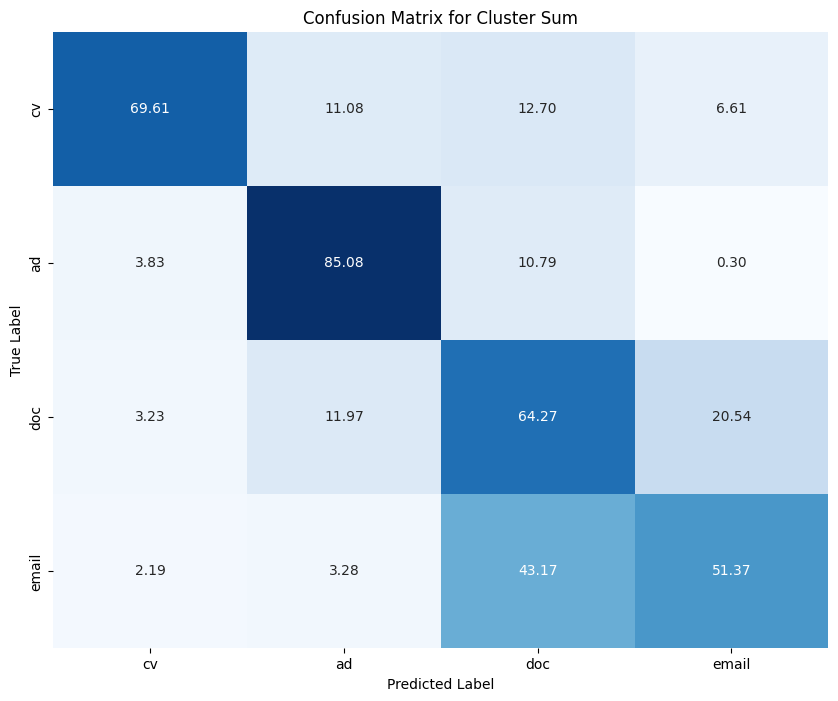

In [21]:
plt.figure(figsize=(10, 8))
sns.heatmap(cluster_sum, annot=True, fmt='.2f', cmap='Blues', cbar=False,
            xticklabels=cluster_sum.columns, yticklabels=cluster_sum.index)

plt.title('Confusion Matrix for Cluster Sum')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()